# Contour length index (CLI)

In [1]:
from IPython.display import HTML
%run ../../_setup.py

import numpy as np
from xarray import open_dataset
import pyproj
import datetime

import matplotlib.pyplot as plt
%matplotlib notebook

Function to calculate contour length for a particular contour.

In [2]:
from skimage import measure

def contour_length(xr_ds, var, contour, timemean=True, time_sel=slice(None, None), lon_sel=slice(None, None), lat_sel=slice(None, None), transform=None):
    
    # take the time mean field
    if time_sel != slice(None, None) and timemean:
        timemean = xr_ds[var].sel(time=time_sel).mean(axis=0)
    elif timemean:
        timemean = xr_ds[var].mean(axis=0)
    else:
        raise ValueError('Field can have a maximum number of 2 dimension but got %s', xr_ds[var].ndim)
    
    # select spatial area
    if lon_sel != slice(None, None):
        ctfield = timemean.sel(longitude=lon_sel)
    if lat_sel != slice(None, None):
        ctfield = timemean.sel(latitude=lat_sel)
    
    # find longest contour
    contours = measure.find_contours(ctfield, contour)
    contour = max(contours, key=lambda x: len(x))

    lon_ct, lat_ct = contour[:, 1], contour[:, 0]
    lon_ct = np.nanmin(ctfield.longitude) + np.unique(np.diff(ctfield.longitude)) * lon_ct
    lat_ct = np.nanmin(ctfield.latitude) + np.unique(np.diff(ctfield.latitude)) * lat_ct

    # transform polar coordinates to cartesian coordinates
    if transform is not None:
        WGS84 = pyproj.Proj('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
        x_ct, y_ct = pyproj.transform(WGS84, transform, lon_ct, lat_ct)
    else:
        x_ct, y_ct = lon_ct, lat_ct

    #  calculate contour length in meters
    dx, dy = np.diff(x_ct), np.diff(y_ct)
    cl = np.sum(np.sqrt(dx**2 + dy**2))
    
    return cl, lon_ct, lat_ct, timemean

In [3]:
input_file = os.path.join(datadir, 'external', 'ssh', 'SEALEVEL_GLO_PHY_L4_REP_OBS_137_-52.4_147_-48_199801-199812.nc')
ssh = open_dataset(input_file)


Calculate and plot annual mean contours and contour length:

In [4]:
# var = 'adt'
# contour = 0.3
# time_sel = '1998-10'
# lon_sel = slice(138, 145)
# lat_sel = slice(None, None)
# timemean = True
UTM54 = pyproj.Proj('+proj=utm +zone=54F +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs')

annualmeancl, lon_ct, lat_ct, timemean = contour_length(ssh, 'adt', 0.15, lon_sel=slice(138, 145), transform=UTM54)

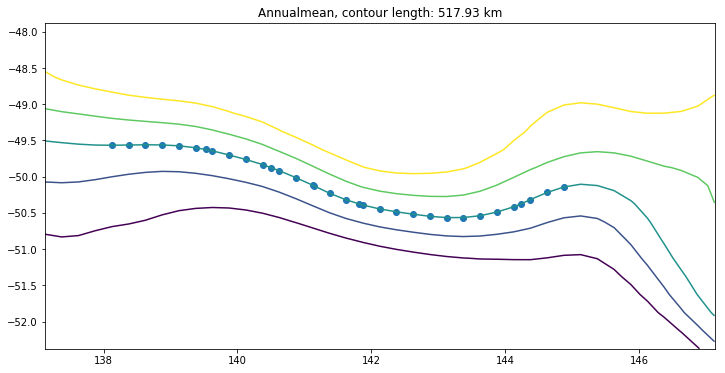

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.contour(ssh.longitude, ssh.latitude, timemean, np.linspace(-0.1, 0.4, 5))
plt.title('Annualmean, contour length: %s km' %round(annualmeancl/1000, 2))
plt.scatter(lon_ct, lat_ct)


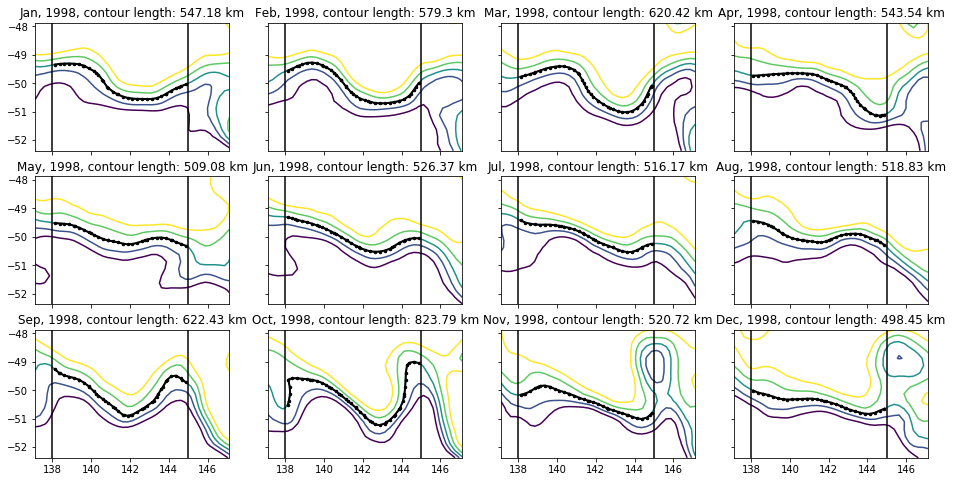

In [6]:
var = 'adt'
contour = 0.15
lon_sel = slice(138, 145)
year = 1998
month = 1

fig, ax = plt.subplots(3, 4, figsize=(16, 8), sharex=True, sharey=True)
rows, cols = ax.shape

cli = []
for row in range(rows):
    for col in range(cols):
        time_sel = '%s-%02d' % (year, month)

        cl, lon_ct, lat_ct, timemean = contour_length(ssh, var, contour, time_sel=time_sel, lon_sel=lon_sel, transform=UTM54)
        cli.append((cl - annualmeancl)/1000)
        ct = ax[row, col].contour(ssh.longitude, ssh.latitude, timemean, np.linspace(-0.1, 0.4, 5))
#         ax[row, col].contour(sl['longitude'][:], sl['latitude'][:], monthlymean, [0.15], colors='r', linewidths=2)
        ax[row, col].plot(lon_ct, lat_ct, 'k.-', linewidth=2, markersize=5)
        ax[row, col].set_title(datetime.date(year, month, 1).strftime('%b, %Y') + ', contour length: %s km' %round(cl/1000, 2))
        ax[row, col].axvline(138, color='k')
        ax[row, col].axvline(145, color='k')

        month += 1

In [7]:
from netCDF4 import Dataset
cl= Dataset(input_file)
print(cl['longitude'][4:-9])
cl['latitude'][2:-3]

[138.125 138.375 138.625 138.875 139.125 139.375 139.625 139.875 140.125
 140.375 140.625 140.875 141.125 141.375 141.625 141.875 142.125 142.375
 142.625 142.875 143.125 143.375 143.625 143.875 144.125 144.375 144.625
 144.875]


masked_array(data=[-51.875, -51.625, -51.375, -51.125, -50.875, -50.625,
                   -50.375, -50.125, -49.875, -49.625, -49.375, -49.125,
                   -48.875, -48.625],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [8]:
## DETERMINE HOVMOLLER
# for each timestep average latitudinal values from -48.6 - -51.8
sla = ssh['sla'].sel(longitude=slice(138, 145), latitude=slice(-51.8, -48.6))
hm = np.ma.masked_all(sla.shape[0::2])
for it in range(len(sla.time)):
    hm[it, :] = np.average(sla[it,], axis=0)

In [9]:
import pandas as pd
pd.date_range(start='1/1/1998', periods=12, freq='M')

df = pd.read_csv(os.path.join(datadir, 'external', 'sam', 'monthly_sam_1957-2007.txt'), sep='\s+')
df.columns = range(1, 13)
df = df.stack()
year = df.index.get_level_values(0).values
month = df.index.get_level_values(1).values

df.index = pd.PeriodIndex(year=year, month=month, freq='M')

df98 = pd.DataFrame(df.loc[df.index.year == 1998], columns=['SAM'])
df98['SAMpos'] = df98['SAM'] > 0
df98['CLI'] = cli
df98['CLIpos'] = df98['CLI'] > 0


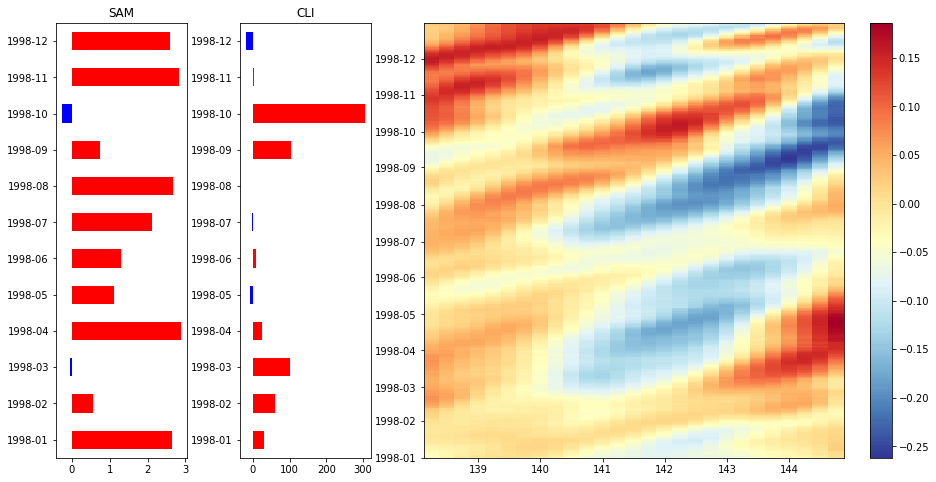

In [10]:
fig, ax = plt.subplots(1,3, gridspec_kw = {'width_ratios':[1, 1, 4]}, figsize = (16,8))
df98['SAM'].plot(kind='barh', ax=ax[0], color=df98.SAMpos.map({True: 'r', False: 'b'}))
df98['CLI'].plot(kind='barh', ax=ax[1], color=df98.CLIpos.map({True: 'r', False: 'b'}))
pcol = ax[2].pcolormesh(sla.longitude, sla.time, hm, cmap=plt.cm.RdYlBu_r)
ax[0].set_title('SAM')
ax[1].set_title('CLI')
plt.colorbar(pcol, ax=ax[2])


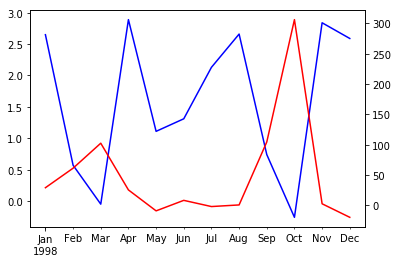

In [11]:
fig, ax = plt.subplots()
ax1 = df98['SAM'].plot(color='b')
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
df98['CLI'].plot(color='r', ax=ax2)

In [10]:
import cdsapi

date = '1998-03-01'

months = ['%02d' % month for month in range(1, 13)]
years = [year for year in range(1993, 2019)]
days = ['%02d' % day for day in range(1, 31)]

area = [-48, 137, -52.4, 147] # North, West, South, East

# filename = os.path.join(datadir, 'external', 'ssh', )

c = cdsapi.Client()

c.retrieve(
    'satellite-sea-level-global',
    {
        'year': '1998',
        'month': '03', #months,
        'day': days,
        'area': area, # North, West, South, East
        'variable': 'adt', #'all',
#         'format': 'netcdf'
    }#, filename
)

2018-10-09 10:02:11,249 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-sea-level-global
2018-10-09 10:02:12,919 INFO Request is queued
2018-10-09 10:02:14,371 INFO Request is running
2018-10-09 10:08:38,726 INFO Request is completed


Result(content_length=161796219,content_type=application/zip,location=http://136.156.132.110/cache-compute-0002/cache/data2/dataset-satellite-sea-level-global-13207fd7-e3ad-433f-b32f-b30b952e6c0d.zip)

In [1]:
%run ../../_setup.py

import cdsapi
# from calendar import monthrange

# def filename(ds, var, year, month):
#     """Construct the name of the variable file with year and month"""
#     return '{ds}_{var}_{year:4d}-{month:02d}.nc'.format(ds=ds, var=var, year=year, month=month)

def filename(ds, var, year):
    """Construct the name of the variable file with year and month"""
    return '{ds}_{var}_{year:4d}.grib'.format(ds=ds, var=var, year=year)

years = (1993, 2018)
months = ['%02d' % month for month in range(1, 12+1)]
days = ['%02d' % day for day in range(1, 31+1)]
area = [-48, 137, -52.4, 147] # North, West, South, East

dirname = os.path.join(datadir, 'external', 'ssh', 'SEALEVEL_GLO_PHY_L4_REP_OBS')
if not os.path.exists(dirname):
    os.makedirs(dirname)

c = cdsapi.Client()

for year in range(1998, 1999+1):
#     for month in range(1, 12+1):
#         ndays = monthrange(year, month)[1]
#         days = ['%02d' % day for day in range(1, ndays+1)]

    fname = filename('sl', 'all', year)
    file = os.path.join(dirname, fname)
    
    if not os.path.isfile(file):
        try:
            print(file)
#             urllib.request.urlretrieve(url + fname, file)
            c.retrieve('satellite-sea-level-global',
                       {
                           'variable': 'all',
                           'year': str(year),
                           'month': '%02d' % 3,
                           'day': days,
                           'area': area,
                           'grid': 0.25/0.25,
#                            'format': 'netcdf'
                       }, os.path.join(dirname, fname)
                      )
        except:
            print('Warning: Could not download: ' + fname)
            if os.path.isfile(file):
                os.remove(file)  



2018-10-09 13:36:13,155 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-sea-level-global


/home/janjaapmeijer/Checkouts/PhD/data/external/ssh/SEALEVEL_GLO_PHY_L4_REP_OBS/sl_all_1998.grib


2018-10-09 13:36:15,026 INFO Request is completed
2018-10-09 13:36:15,028 INFO Downloading http://136.156.132.110/cache-compute-0003/cache/data2/dataset-satellite-sea-level-global-a682741d-0862-4945-ba81-ad36b1500f45.zip to /home/janjaapmeijer/Checkouts/PhD/data/external/ssh/SEALEVEL_GLO_PHY_L4_REP_OBS/sl_all_1998.grib (159.4M)


Exception ignored in: <bound method Result.__del__ of Result(content_length=167149874,content_type=application/zip,location=http://136.156.132.110/cache-compute-0003/cache/data2/dataset-satellite-sea-level-global-a682741d-0862-4945-ba81-ad36b1500f45.zip)>
Traceback (most recent call last):
  File "/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/cdsapi/api.py", line 143, in __del__
    self.delete()
  File "/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/cdsapi/api.py", line 129, in delete
    delete = self.session.delete(task_url, verify=self.verify)
  File "/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/requests/sessions.py", line 591, in delete
    return self.request('DELETE', url, **kwargs)
  File "/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/requests/sessions.py", line 512, in request
    resp = self.send(prep, **send_kwargs)
  File "/home/janjaapmeijer/miniconda3/envs/ocean36/lib/p

/home/janjaapmeijer/Checkouts/PhD/data/external/ssh/SEALEVEL_GLO_PHY_L4_REP_OBS/sl_all_1999.grib


2018-10-09 13:36:26,378 INFO Request is queued
2018-10-09 13:36:27,727 INFO Request is running


<IPython.core.display.Javascript object>


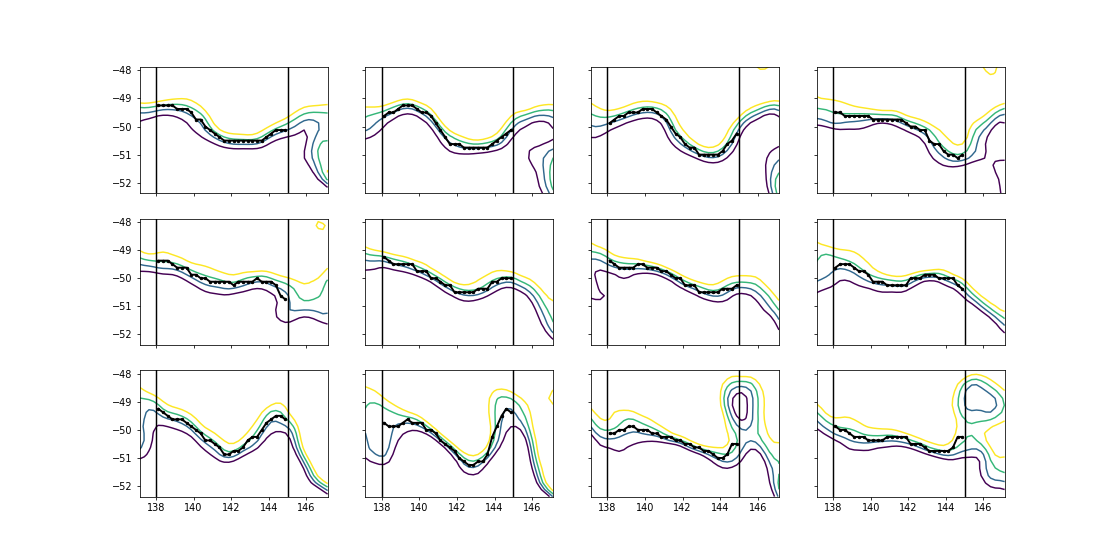

<IPython.core.display.Javascript object>


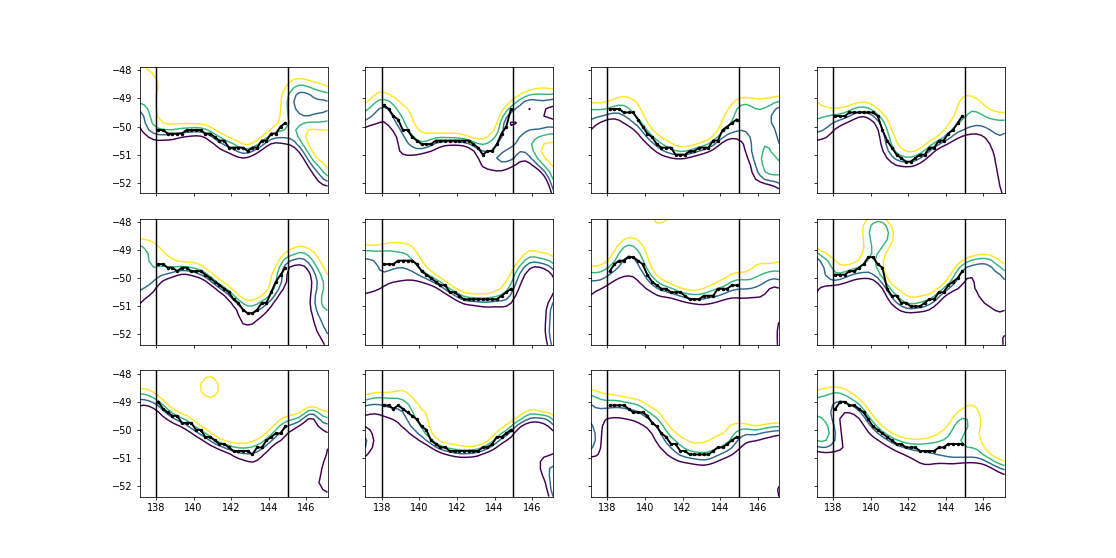

<IPython.core.display.Javascript object>


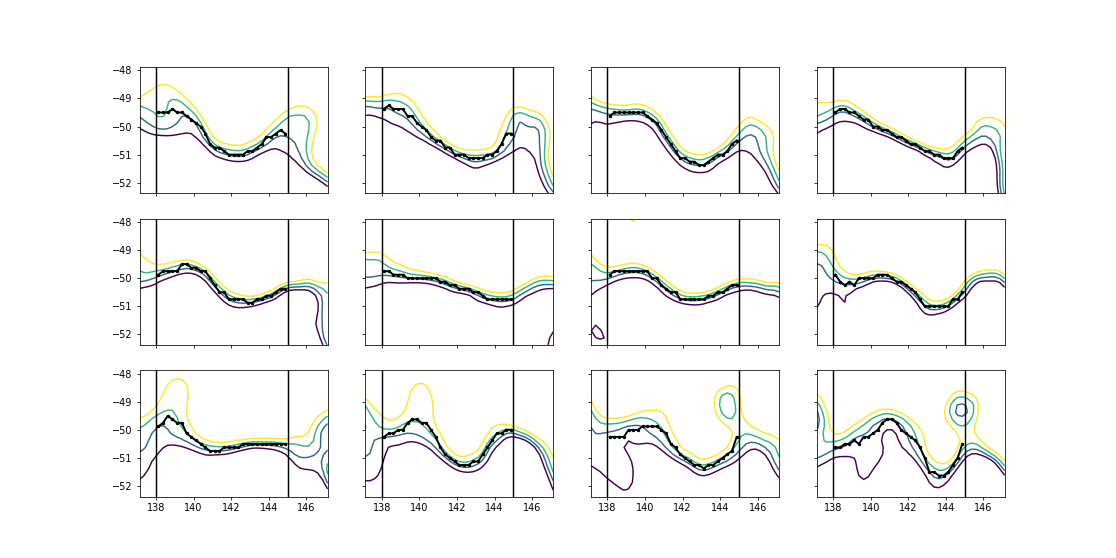

In [39]:
%matplotlib qt
lon, lat = sl['longitude'][:], sl['latitude'][:]

time = num2date(sl['time'][:], sl['time'].units)
# idx = [t.month == month for t in time]

nyr = 2000


sel = slice(4, 32)


cli = []
for nyr in range(1998, 2001):
    
    fig, ax = plt.subplots(3, 4, figsize=(16, 8), sharex=True, sharey=True)
    rows, cols = ax.shape
    row, col = 0, 0
    
    year = [t.year == nyr for t in time]    
    annualmean = np.mean(sl['adt'][year,], axis=0)
    amcl, lat_ct = contour_length(lon[sel], lat, annualmean[:, sel], contour_range=(0, 0.3))
    
#     plt.contour(lon, lat, annualmean, [-0.1, 0, 0.1, 0.2, 0.3, 0.4]) # 
#     plt.plot(lon[sel], lat_ct, 'k.-', linewidth=4, )
#     plt.title('contour length: %s' %round(annualmeancl, 2))
    
    for nmth in range(1, 13):
        month = [(t.year == nyr) & (t.month == nmth) for t in time]
        monthlymean = np.mean(sl['adt'][month,], axis=0)

        mmcl, lat_ct = contour_length(lon[sel], lat, monthlymean[:, sel], contour_range=(0, 0.3))
        cli.append(mmcl - amcl)
        

        ct = ax[row, col].contour(sl['longitude'][:], sl['latitude'][:], monthlymean, np.linspace(0, 0.3, 4)) #[-0.1, 0, 0.1, 0.2, 0.3, 0.4]
#         ax[row, col].contour(sl['longitude'][:], sl['latitude'][:], monthlymean, [0.15], colors='r', linewidths=2)
        ax[row, col].plot(lon[sel], lat_ct, 'k.-', linewidth=2, markersize=5)
#         ax[row, col].set_title('%s, contour length: %s' %(month, round(cl, 2)))
        ax[row, col].axvline(138, color='k')
        ax[row, col].axvline(145, color='k')
        
        col += 1
        if col % cols == 0:
            col = 0
            row += 1
        
        plt.show()

        
#   for row in range(rows):
#     for col in range(cols):
#         idx = [t.month == month for t in time]

#         monthlymean = np.mean(sl['adt'][idx,], axis=0)
#         cl, lat_ct = contour_length(lon[4:32], lat, monthlymean[:, 4:32], contour_range=(0, 0.3))
#         cli.append(cl - annualmeancl)
#         ct = ax[row, col].contour(sl['longitude'][:], sl['latitude'][:], monthlymean, np.linspace(-0.1, 0.4, 5)) #[-0.1, 0, 0.1, 0.2, 0.3, 0.4]
#         ax[row, col].contour(sl['longitude'][:], sl['latitude'][:], monthlymean, [0.15], colors='r', linewidths=2)
#         ax[row, col].plot(lon[4:32], lat_ct, 'k.-', linewidth=2, markersize=5)
#         ax[row, col].set_title('%s, contour length: %s' %(month, round(cl, 2)))
#         ax[row, col].axvline(138, color='k')
#         ax[row, col].axvline(145, color='k')






<IPython.core.display.Javascript object>


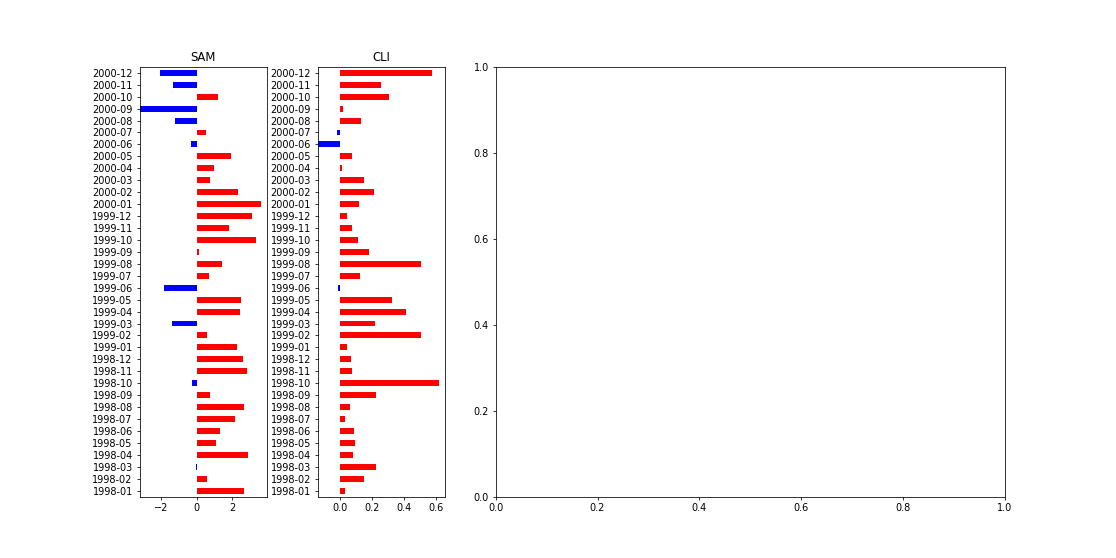

In [40]:
df_new = pd.DataFrame(df.loc[(df.index.year >= 1998) & (df.index.year < 2001) ], columns=['SAM'])
df_new['SAMpos'] = df_new['SAM'] > 0
df_new['CLI'] = cli
df_new['CLIpos'] = df_new['CLI'] > 0

fig, ax = plt.subplots(1,3, gridspec_kw = {'width_ratios':[1, 1, 4]}, figsize = (16,8))
df_new['SAM'].plot(kind='barh', ax=ax[0], color=df_new.SAMpos.map({True: 'r', False: 'b'}))
df_new['CLI'].plot(kind='barh', ax=ax[1], color=df_new.CLIpos.map({True: 'r', False: 'b'}))
# pcol = ax[2].pcolormesh(sl['longitude'][4:-9], time, hm, cmap=plt.cm.RdYlBu_r)
ax[0].set_title('SAM')
ax[1].set_title('CLI')
# plt.colorbar(pcol, ax=ax[2])


<IPython.core.display.Javascript object>


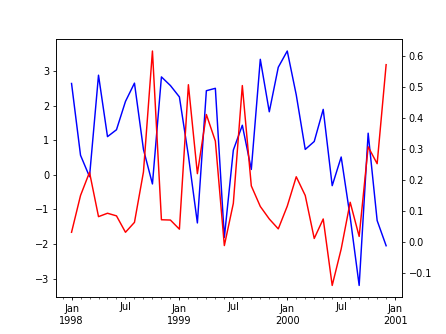

In [41]:
fig, ax = plt.subplots()
ax1 = df_new['SAM'].plot(color='b')
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
df_new['CLI'].plot(color='r', ax=ax2)

In [1]:
from IPython.display import HTML

%run ../../_setup.py

import numpy as np
import datetime

from netCDF4 import Dataset, num2date

from OceanPy.animations import play2D

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
input_file = os.path.join(datadir, 'external', 'ssh', 'SEALEVEL_GLO_PHY_L4_REP_OBS_137_-52.4_147_-48_199801-199812.nc')
sl = Dataset(input_file)
# sl.variables.keys()

lon, lat = sl['longitude'][:], sl['latitude'][:]

sl['adt']

<class 'netCDF4._netCDF4.Variable'>
int32 adt(time, latitude, longitude)
    _FillValue: -2147483647
    comment: The absolute dynamic topography is the sea surface height above geoid; the adt is obtained as follows: adt=sla+mdt where mdt is the mean dynamic topography; see the product user manual for details
    coordinates: time latitude longitude 
    grid_mapping: crs
    long_name: Absolute dynamic topography
    scale_factor: 0.0001
    standard_name: sea_surface_height_above_geoid
    units: m
unlimited dimensions: 
current shape = (365, 19, 41)
filling on

In [3]:

def contour_length(lon, lat, var, contour_range=(-0.1, 0.4)): #contour_center= , 
    
    contour_center = (contour_range[1] - contour_range[0]) / 2
            
    lat_ct = []
    cl = 0
    
    # for each longitudinal grid cell from west to east
    for iln in range(len(lon)):
        
        # find latitudinal indices within contour range
        ilt = np.where((var[:, iln] < contour_range[1]) & (var[:, iln] > contour_range[0]))[0]

        # find latitudinal index of center contour, but not further than one latitudinal step away from previous
#         iltc = (np.abs(var[:,iln] - contour_center)).argmin()
        iltc = np.argsort(np.abs(var[:, iln] - contour_center))
        if iln > 0:
            i = 0
            while np.abs(iltc[i] - iltcprev) >= 3:
                i += 1
            iltc = iltc[i]
        else:
            iltc = iltc[0]
        iltcprev = iltc
        
        # determine mean latitude in contour range
        lats = lat[ilt]
        if len(ilt) > 1:
            try:
                ic = np.where(ilt == iltc)[0][0]
            except IndexError:
                print(ilt, iltc)
            trueidx = np.zeros(len(ilt), dtype=bool)
            trueidx[ic] = True
            
            # find latitudinal indices that are consecutive/ contiguous from center contour
            contiguous = iltc
#             print(ilt)
            for i in range(ic+1, len(ilt)):
                if (ilt[i] == contiguous + 1) & (np.abs(contiguous - iltc) <= 3): #and not ilt[i] > iltc + 3:
                    trueidx[i] = True
                contiguous += 1
            contiguous = iltc
            for i in reversed(range(0, ic)):
                if (ilt[i] == contiguous - 1)  & (np.abs(contiguous - iltc) <= 3): #and not ilt[i] < iltc - 3:
                    trueidx[i] = True
                contiguous -= 1
#             print(trueidx)
            lat_mean = np.mean(lats[trueidx])
          
        elif len(ilt) == 1:
            lat_mean = lat[iltc]
        
        lat_ct.append(lat_mean)
     
#         # find latitude for prescribed contour value
#         ilt = (np.abs(var[:,iln] - contour)).argmin()
#         lat_ct.append(lat[ilts])

        # calculate latitudinal and longitudinal increments and calculate contour length
        if iln > 0:
            dlon = lon[iln] - lon[iln-1]
            dlat = lat_ct[iln] - lat_ct[iln-1]
            
#             print(dlon, dlat)

            cl += np.sqrt(dlon*2 + dlat**2)
        
    return cl, lat_ct


In [4]:

def contour_length(lon, lat, var, contour_range=(-0.1, 0.4)): #contour_center= , 
    
    contour_center = (contour_range[1] - contour_range[0]) / 2
            
    lat_ct = []
    cl = 0
    
    # for each longitudinal grid cell from west to east
    for iln in range(len(lon)):
        
        # find latitudinal indices within contour range
        ilt = np.where((var[:, iln] < contour_range[1]) & (var[:, iln] > contour_range[0]))[0]

        # find latitudinal index of center contour, but not further than one latitudinal step away from previous
#         iltc = (np.abs(var[:,iln] - contour_center)).argmin()
        iltc = np.argsort(np.abs(var[:, iln] - contour_center))
        if iln > 0:
            i = 0
            while np.abs(iltc[i] - iltcprev) >= 3:
                i += 1
            iltc = iltc[i]
        else:
            iltc = iltc[0]
        iltcprev = iltc
        
        # determine mean latitude in contour range
        lats = lat[ilt]
        if len(ilt) > 1:
            try:
                ic = np.where(ilt == iltc)[0][0]
            except IndexError:
                print(ilt, iltc)
            trueidx = np.zeros(len(ilt), dtype=bool)
            trueidx[ic] = True
            
            # find latitudinal indices that are consecutive/ contiguous from center contour
            contiguous = iltc
#             print(ilt)
            for i in range(ic+1, len(ilt)):
                if (ilt[i] == contiguous + 1) & (np.abs(contiguous - iltc) <= 3): #and not ilt[i] > iltc + 3:
                    trueidx[i] = True
                contiguous += 1
            contiguous = iltc
            for i in reversed(range(0, ic)):
                if (ilt[i] == contiguous - 1)  & (np.abs(contiguous - iltc) <= 3): #and not ilt[i] < iltc - 3:
                    trueidx[i] = True
                contiguous -= 1
#             print(trueidx)
            lat_mean = np.mean(lats[trueidx])
          
        elif len(ilt) == 1:
            lat_mean = lat[iltc]
        
        lat_ct.append(lat_mean)
     
#         # find latitude for prescribed contour value
#         ilt = (np.abs(var[:,iln] - contour)).argmin()
#         lat_ct.append(lat[ilts])

        # calculate latitudinal and longitudinal increments and calculate contour length
        if iln > 0:
            dlon = lon[iln] - lon[iln-1]
            dlat = lat_ct[iln] - lat_ct[iln-1]
            
#             print(dlon, dlat)

            cl += np.sqrt(dlon*2 + dlat**2)
        
    return cl, lat_ct


In [5]:
annualmean = np.mean(sl['adt'], axis=0)
annualmeancl, lat_ct = contour_length(lon[4:32], lat, annualmean[:, 4:32], contour_range=(0, 0.3))

# annualmean = np.mean(sl['adt'][60:80], axis=0)
print(annualmean.shape, lon[4:32].shape, lat.shape)

(19, 41) (28,) (19,)


Text(0.5,1,'contour length: 19.24')

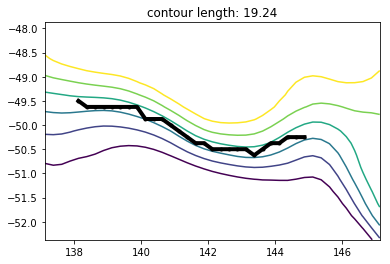

In [6]:
plt.contour(sl['longitude'][:], sl['latitude'][:], annualmean, [-0.1, 0, 0.1, 0.2, 0.3, 0.4])
plt.plot(lon[4:32], lat_ct, 'k.-', linewidth=4, )
plt.title('contour length: %s' %round(annualmeancl, 2))

In [7]:
time = num2date(sl['time'][:], sl['time'].units)
# determine time of the voyage
time = sl['time']
time = num2date(time[:], time.units)
# begin = datetime.datetime(1998, 3, 10)
# end = datetime.datetime(1998, 3, 28)

# timevoy = np.array([begin <= t <= end for t in time])

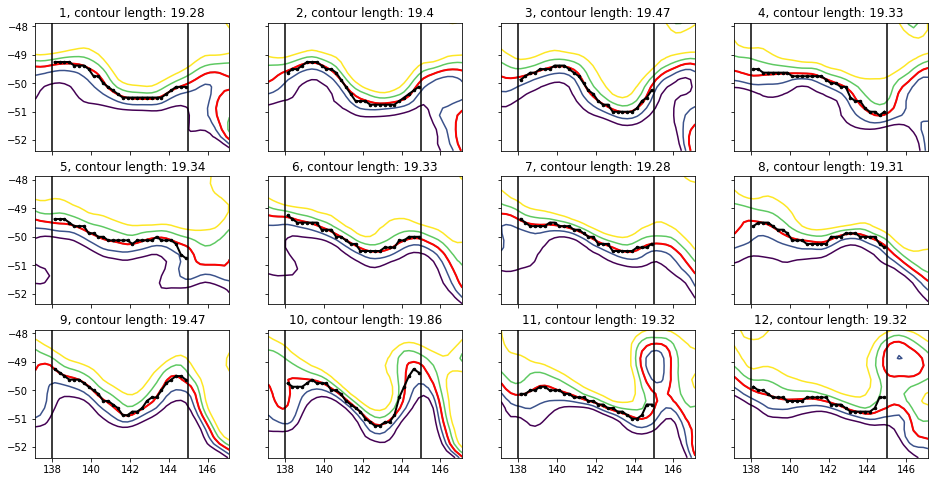

In [8]:
fig, ax = plt.subplots(3, 4, figsize=(16, 8), sharex=True, sharey=True)
rows, cols = ax.shape
month = 1

cli = []
for row in range(rows):
    for col in range(cols):
        idx = [t.month == month for t in time]

        monthlymean = np.mean(sl['adt'][idx,], axis=0)
        cl, lat_ct = contour_length(lon[4:32], lat, monthlymean[:, 4:32], contour_range=(0, 0.3))
        cli.append(cl - annualmeancl)
        ct = ax[row, col].contour(sl['longitude'][:], sl['latitude'][:], monthlymean, np.linspace(-0.1, 0.4, 5)) #[-0.1, 0, 0.1, 0.2, 0.3, 0.4]
        ax[row, col].contour(sl['longitude'][:], sl['latitude'][:], monthlymean, [0.15], colors='r', linewidths=2)
        ax[row, col].plot(lon[4:32], lat_ct, 'k.-', linewidth=2, markersize=5)
        ax[row, col].set_title('%s, contour length: %s' %(month, round(cl, 2)))
        ax[row, col].axvline(138, color='k')
        ax[row, col].axvline(145, color='k')

        month += 1

In [29]:
month=11
idx = [t.month == month for t in time]
monthlymean = np.mean(sl['adt'][idx,], axis=0)
cl, lat_ct = contour_length(lon[4:32], lat, monthlymean[:, 4:32], contour_range=(0.0,0.3))

# fig, ax = plt.subplots()
# ct = ax.contour(sl['longitude'][:], sl['latitude'][:], monthlymean, [0, 0.15, 0.3])
# ax.plot(lon[4:32], lat_ct, 'k.-', linewidth=2, markersize=4)


In [30]:
sl.variables.keys()

odict_keys(['err', 'time', 'latitude', 'longitude', 'vgosa', 'vgos', 'sla', 'ugosa', 'adt', 'ugos'])

In [31]:
sl['sla']

<class 'netCDF4._netCDF4.Variable'>
int32 sla(time, latitude, longitude)
    _FillValue: -2147483647
    comment: The sea level anomaly is the sea surface height above mean sea surface; it is referenced to the [1993, 2012] period; see the product user manual for details
    coordinates: time latitude longitude 
    grid_mapping: crs
    long_name: Sea level anomaly
    scale_factor: 0.0001
    standard_name: sea_surface_height_above_sea_level
    units: m
unlimited dimensions: 
current shape = (365, 19, 41)
filling on

* Check with movie what red/ blue patches mean, red patches seem to indicate Rossby wave travelling eastward and blue patches should show in movie as Rossby waves travelling westward
* Discuss with supervisors if necessary to do this analysis for all years of valid altimetry and discuss improvement of script for calculating the contour length (see notes) and SAM index or average wind area location upstream of meander

In [10]:
%run ../../_setup.py
from xarray import open_dataset
# input_file = os.path.join(datadir, 'external', 'ssh', 'SEALEVEL_GLO_PHY_L4_REP_OBS_137_-52.4_147_-48_199801-199812.nc')
# ssh = open_dataset(input_file)
input_file = os.path.join(datadir, 'external', 'ssh', 'SEALEVEL_GLO_PHY_L4_REP_OBS_137_-52.4_147_-48_199801-199812.nc')
sl = Dataset(input_file)

In [74]:
import matplotlib.pyplot as plt
import pyproj
# contours = measure.find_contours(r, 0.8)

In [12]:
annualmean = np.mean(sl['adt'], axis=0)
annualmeancl, lat_ct = contour_length(lon[4:32], lat, annualmean[:, 4:32], contour_range=(0, 0.3))

# annualmean = np.mean(sl['adt'][60:80], axis=0)
print(annualmean.shape, lon[4:32].shape, lat.shape)

(19, 41) (28,) (19,)


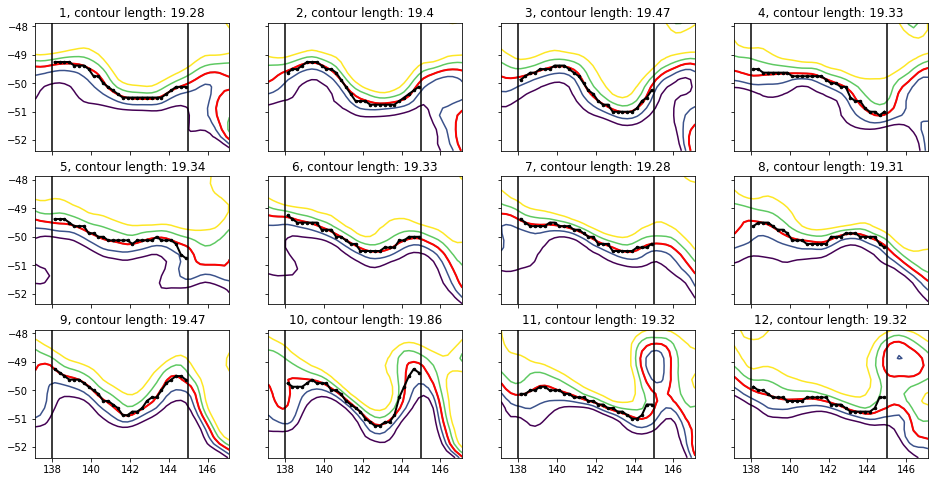

In [13]:
fig, ax = plt.subplots(3, 4, figsize=(16, 8), sharex=True, sharey=True)
rows, cols = ax.shape
month = 1

cli = []
for row in range(rows):
    for col in range(cols):
        idx = [t.month == month for t in time]

        monthlymean = np.mean(sl['adt'][idx,], axis=0)
        cl, lat_ct = contour_length(lon[4:32], lat, monthlymean[:, 4:32], contour_range=(0, 0.3))
        cli.append(cl - annualmeancl)
        ct = ax[row, col].contour(sl['longitude'][:], sl['latitude'][:], monthlymean, np.linspace(-0.1, 0.4, 5)) #[-0.1, 0, 0.1, 0.2, 0.3, 0.4]
        ax[row, col].contour(sl['longitude'][:], sl['latitude'][:], monthlymean, [0.15], colors='r', linewidths=2)
        ax[row, col].plot(lon[4:32], lat_ct, 'k.-', linewidth=2, markersize=5)
        ax[row, col].set_title('%s, contour length: %s' %(month, round(cl, 2)))
        ax[row, col].axvline(138, color='k')
        ax[row, col].axvline(145, color='k')

        month += 1

In [76]:
var = 'adt'
contour = 0.3
time_sel = '1998-10'
lon_sel = slice(138, 145)
lat_sel = slice(None, None)
timemean = True
transform = UTM54 = pyproj.Proj('+proj=utm +zone=54F +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs')

xr_ds = open_dataset(input_file)

from skimage import measure
def contour_length(xr_ds, var, contour, timemean=True, time_sel=slice(None, None), lon_sel=slice(None, None), lat_sel=slice(None, None))
    # take the time mean field
    if time_sel != slice(None, None) and timemean:
        timemean = xr_ds[var].sel(time=time_sel).mean(axis=0)
    elif timemean:
        timemean = xr_ds[var].mean(axis=0)
    else:
        raise ValueError('Field can have a maximum number of 2 dimension but got %s', xr_ds[var].ndim)
    
    # select spatial area
    if lon_sel != slice(None, None):
        ctfield = timemean.sel(longitude=lon_sel)
    if lat_sel != slice(None, None):
        ctfield = timemean.sel(latitude=lat_sel)
    
    # find longest contour
    contours = measure.find_contours(ctfield, contour)
    contour = max(contours, key=lambda x: len(x))

    lon_ct, lat_ct = contour[:, 1], contour[:, 0]
    lon_ct = np.nanmin(ctfield.longitude) + np.unique(np.diff(ctfield.longitude)) * lon_ct
    lat_ct = np.nanmin(ctfield.latitude) + np.unique(np.diff(ctfield.latitude)) * lat_ct

    # transform polar coordinates to cartesian coordinates
    WGS84 = pyproj.Proj('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
    x_ct, y_ct = pyproj.transform(WGS84, UTM54, lon_ct, lat_ct)

    #  calculate contour length in meters
    dx, dy = np.diff(x_ct), np.diff(y_ct)
    cl = np.sum(np.sqrt(dx**2 + dy**2))
    
    return cl, lon_cl, lat_cl, timemean

Text(0.5,1,'776369.0302461518')

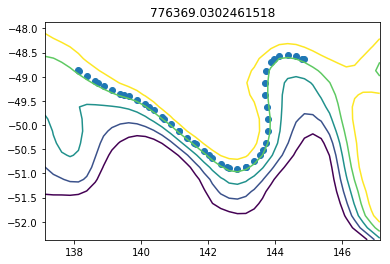

In [77]:
plt.contour(xr_ds.longitude, xr_ds.latitude, timemean, np.linspace(-0.1, 0.4, 5))
# plt.plot(lon[4:32], lat_ct, 'k.-', linewidth=4, )
# plt.title('contour length: %s' %round(annualmeancl, 2))
plt.scatter(lon_ct, lat_ct)
plt.title(str(cl))